In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.color import rgba2rgb, rgb2gray
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.nn import MaxUnpool2d
from torchvision import models
from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -u "/content/drive/MyDrive/CVPPPSegmData.zip" -d "/content/"

Archive:  /content/drive/MyDrive/CVPPPSegmData.zip
   creating: /content/CVPPPSegmData/
   creating: /content/CVPPPSegmData/data/
   creating: /content/CVPPPSegmData/data/A1/
  inflating: /content/CVPPPSegmData/data/A1/A1.csv  
 extracting: /content/CVPPPSegmData/data/A1/plant001_centers.png  
  inflating: /content/CVPPPSegmData/data/A1/plant001_fg.png  
  inflating: /content/CVPPPSegmData/data/A1/plant001_label.png  
 extracting: /content/CVPPPSegmData/data/A1/plant001_rgb.png  
 extracting: /content/CVPPPSegmData/data/A1/plant002_centers.png  
  inflating: /content/CVPPPSegmData/data/A1/plant002_fg.png  
  inflating: /content/CVPPPSegmData/data/A1/plant002_label.png  
 extracting: /content/CVPPPSegmData/data/A1/plant002_rgb.png  
 extracting: /content/CVPPPSegmData/data/A1/plant005_centers.png  
  inflating: /content/CVPPPSegmData/data/A1/plant005_fg.png  
  inflating: /content/CVPPPSegmData/data/A1/plant005_label.png  
 extracting: /content/CVPPPSegmData/data/A1/plant005_rgb.png  
 

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [6]:
split=pd.read_csv('/content/CVPPPSegmData/split.csv')

In [7]:
images_train = []
semantic_train = []
instance_train = []
images_dev = []
semantic_dev = []
instance_dev = []
images_test = []
semantic_test = []
instance_test = []

for _, row in split.iterrows():
  if row[0] == 'train':
    images_train.append(imread(os.path.join("/content/CVPPPSegmData/", row[1])))
    semantic_train.append(imread(os.path.join("/content/CVPPPSegmData/", row[2])))
    instance_train.append(imread(os.path.join("/content/CVPPPSegmData/", row[3])))
  elif row[0] == 'dev':
    images_dev.append(imread(os.path.join("/content/CVPPPSegmData/", row[1])))
    semantic_dev.append(imread(os.path.join("/content/CVPPPSegmData/", row[2])))
    instance_dev.append(imread(os.path.join("/content/CVPPPSegmData/", row[3])))
  elif row[0] == 'test':
    images_test.append(imread(os.path.join("/content/CVPPPSegmData/", row[1])))
    semantic_test.append(imread(os.path.join("/content/CVPPPSegmData/", row[2])))
    instance_test.append(imread(os.path.join("/content/CVPPPSegmData/", row[3])))

<ipython-input-7-4a012e40d7b1>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] == 'train':
<ipython-input-7-4a012e40d7b1>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  images_train.append(imread(os.path.join("/content/CVPPPSegmData/", row[1])))
<ipython-input-7-4a012e40d7b1>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  semantic_train.append(imread(os.path.join("/content/CVPPPSegmData/", row[2])))
<ipython-input-

In [8]:
def process_images_or_instance(images, size):
  return np.array([resize(x, size, mode='constant') if x.shape[-1] == 3 else resize(rgba2rgb(x), size, mode='constant') for x in images], np.float32)

def process_semantic(images, size):
  return np.array([resize(x, size, mode='constant') if len(x.shape) == 2 else resize(rgb2gray(x), size, mode='constant') for x in images], np.float32)

In [9]:
size = (256, 256)
images_train = process_images_or_instance(images_train, size)
semantic_train = process_semantic(semantic_train, size)
instance_train = process_images_or_instance(instance_train, size)
images_dev = process_images_or_instance(images_dev, size)
semantic_dev = process_semantic(semantic_dev, size)
instance_dev = process_images_or_instance(instance_dev, size)
images_test = process_images_or_instance(images_test, size)
semantic_test = process_semantic(semantic_test, size)
instance_test = process_images_or_instance(instance_test, size)

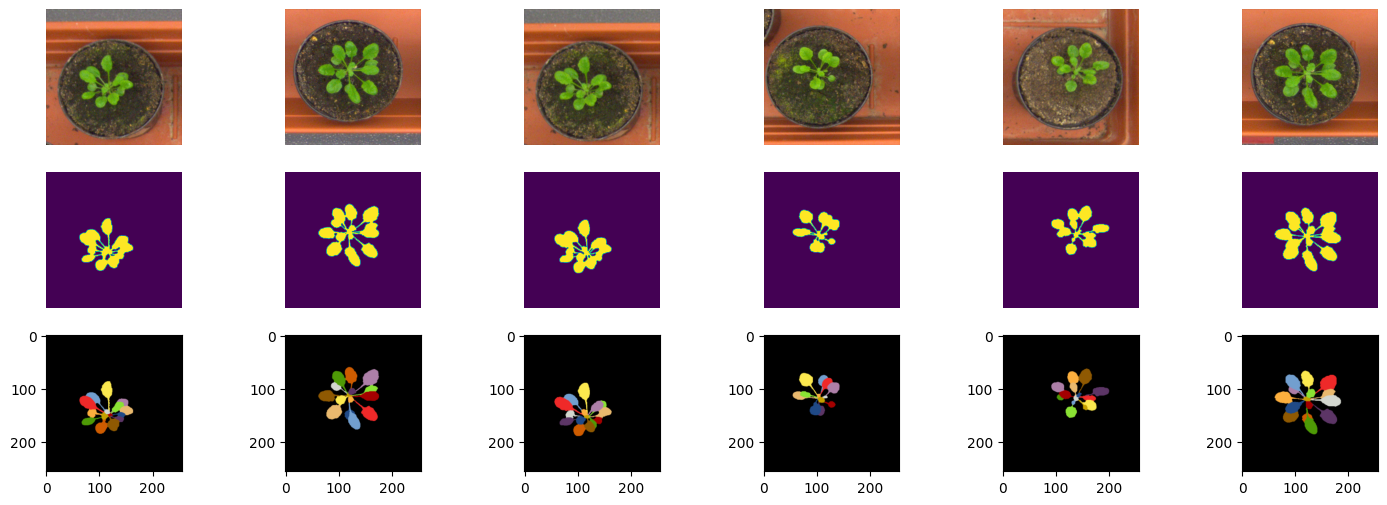

In [11]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(images_train[i])

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(semantic_train[i])
    plt.axis("off")
    plt.subplot(3, 6, i+13)
    plt.imshow(instance_train[i])
plt.show();

In [12]:
def random_transform(x, y):
    if np.random.choice([0,1]):
      x, y = TF.hflip(x), TF.hflip(y)
    if np.random.choice([0,1]):
      x, y = TF.vflip(x), TF.vflip(y)
    if np.random.choice([0,1]):
      x, y = TF.rotate(x, 90), TF.rotate(y, 90)
    return x, y

In [13]:
class Semantic(Dataset):
    def __init__(self, data, train=False):
        super().__init__()

        self.data = data
        self.len_ = len(self.data)
        self.train = train

        for i in range(len(data)):
            self.data[i] = TF.to_tensor(data[i][0]), TF.to_tensor(data[i][1])

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        x, y = self.data[index]
        if self.train:
            x, y = random_transform(x, y)

        return x, y


In [14]:
batch_size = 25
data_sem_tr = DataLoader(Semantic(list(zip(images_train, semantic_train)), train=True), batch_size=batch_size, shuffle=True)
data_sem_dev = DataLoader(Semantic(list(zip(images_dev, semantic_dev)), train = False), batch_size=batch_size, shuffle=True)
data_sem_test = DataLoader(Semantic(list(zip(images_test, semantic_test)), train = False), batch_size=batch_size, shuffle=True)

In [15]:
def conv_layer(chann_in, chann_out, kernel_size=3, padding_size=0, padding_mode='zeros', stride=1):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=kernel_size,
                  padding=padding_size, padding_mode=padding_mode, stride=stride),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

In [16]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            conv_layer(3, 16, 3, 1, 'reflect'),
            conv_layer(16, 16, 3, 1, 'reflect'),
        )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            conv_layer(16, 32, 3, 1, 'reflect'),
            conv_layer(32, 32, 3, 1, 'reflect'),
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            conv_layer(32, 64, 3, 1, 'reflect'),
            conv_layer(64, 64, 3, 1, 'reflect'),
        )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            conv_layer(64, 128, 3, 1, 'reflect'),
            conv_layer(128, 128, 3, 1, 'reflect'),
        )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)

        self.bottleneck_conv = conv_layer(128, 128, 3, 1, 'reflect')

        self.upsample0 = MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            conv_layer(256, 128, 3, 1, 'reflect'),
            conv_layer(128, 64, 3, 1, 'reflect'),
        )
        self.upsample1 = MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            conv_layer(128, 64, 3, 1, 'reflect'),
            conv_layer(64, 32, 3, 1, 'reflect'),
        )
        self.upsample2 = MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            conv_layer(64, 32, 3, 1, 'reflect'),
            conv_layer(32, 16, 3, 1, 'reflect'),
        )
        self.upsample3 = MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            conv_layer(32, 16, 3, 1, 'reflect'),
            nn.Conv2d(16, 1, kernel_size=3,
                      padding=1, padding_mode='reflect', stride=1),
            # nn.ReLU()
            nn.LayerNorm((256, 256))
        )

    def forward(self, x):
        conv0 = self.enc_conv0(x)
        x, i0 = self.pool0(conv0)

        conv1 = self.enc_conv1(x)
        x, i1 = self.pool1(conv1)

        conv2 = self.enc_conv2(x)
        x, i2 = self.pool2(conv2)

        conv3 = self.enc_conv3(x)
        x, i3 = self.pool3(conv3)

        x = self.bottleneck_conv(x)

        x = self.upsample0(x, i3)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec_conv0(x)

        x = self.upsample1(x, i2).to(device)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec_conv1(x)

        x = self.upsample2(x, i1)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec_conv2(x)

        x = self.upsample3(x, i0)
        x = torch.cat([x, conv0], dim=1)
        x = self.dec_conv3(x)
        shape = x.shape
        x = x.view(x.size(0), -1)
        x -= x.min(1, keepdim=True)[0]
        x /= x.max(1, keepdim=True)[0]
        x = x.view(shape)
        return x


In [17]:
def plot_loss(losses, scores):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    ax[0].plot(losses[0], label="train_loss")
    ax[0].plot(losses[1], label="val_loss")
    ax[0].legend(loc='best')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
    ax[0].grid(which="both")

    ax[1].plot(scores[0], label="train_score")
    ax[1].plot(scores[1], label="val_score")
    ax[1].legend(loc='best')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("loss")
    ax[1].grid(which="both")

    plt.show()

In [23]:
def predict(model, data):
    model.eval()
    Y_pred = model(data.to(device)) > 0.5
    return Y_pred

In [27]:
def dice_loss(y_real, y_pred):
    res = 0
    for i in range(len(y_pred)):
      num = (2 * y_real[i] * y_pred[i] + 1).sum()
      den = (y_real[i] + y_pred[i] + 1).sum()
      loss = 1 - num / den
      res += loss
    return res


def score_model(model, metric, data):
    model.eval()
    X, Y = None, None
    scores = []
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch.to(device))
        scores.append(metric(Y_pred, Y_label.to(device)).mean().item())
    return np.array(scores).mean()

In [28]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None, name=""):
    X_val, Y_val = next(iter(data_val))
    losses = []
    val_losses = []
    scores = []
    val_scores = []

    max_val_score = 0

    for epoch in range(epochs):
        avg_loss = 0
        avg_val_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()

            Y_pred = model(X_batch)

            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()

            avg_loss += loss / len(data_tr)
            del X_batch, Y_batch
            torch.cuda.empty_cache()

        model.eval()
        for X_batch, Y_batch in data_val:
            with torch.no_grad():
              X_batch = X_batch.to(device)
              Y_batch = Y_batch.to(device)
              Y_pred = model(X_batch)
              val_loss = loss_fn(Y_pred, Y_batch)

              avg_val_loss += val_loss / len(data_val)
              del X_batch, Y_batch
              torch.cuda.empty_cache()

        losses += [avg_loss.item()]
        val_losses += [avg_val_loss.item()]
        val_scores += [score_model(model, loss_fn, data_val)]
        scores += [score_model(model, loss_fn, data_tr)]

        if name != "":
            if max_val_score < val_scores[-1]:
                max_val_score = val_scores[-1]

        model.eval()
        Y_hat = model(X_val.to(device)).cpu().detach().numpy()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch+1}/{epochs}\nloss: {avg_loss}\nval_loss: {avg_val_loss}')
        plt.subplots_adjust(top=0.7)
        plt.show()

    return losses, val_losses, scores, val_scores

In [29]:
def bce_loss(y_pred, y_real):
    y_pred = y_pred.long()
    y_real = y_real.long()
    return torch.mean(torch.clamp(y_pred, min=0)-y_pred*y_real+torch.log(1+torch.exp(-torch.abs(y_pred))))

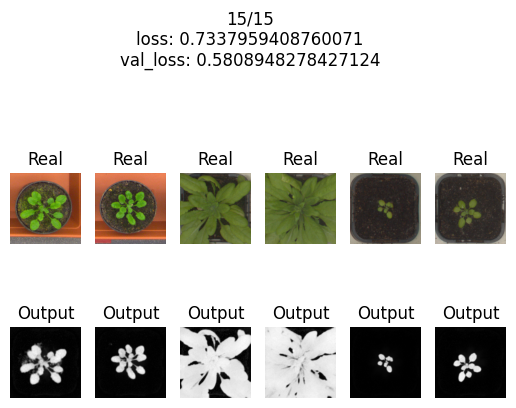

In [30]:
max_epochs = 15
model = UNet().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses, scores, val_scores = train(model, optim, dice_loss, max_epochs, data_sem_tr, data_sem_dev, scheduler)

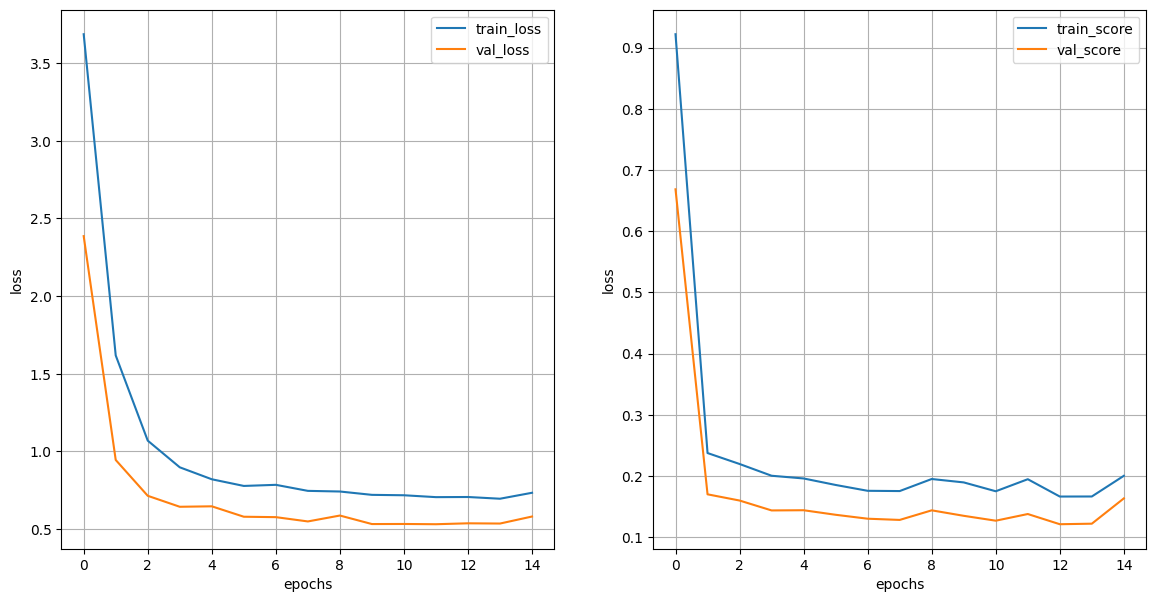

In [31]:
plot_loss([losses, val_losses], [scores, val_scores])

In [32]:
model.eval()
X_val, Y_val = next(iter(data_sem_test))
Y_hat = torch.where(model(X_val.to(device)).cpu().detach() > 0.5, 1.0, 0.0).numpy()

<ipython-input-33-493ee2dc79ac>:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  plt.imshow(X_val[i].T)


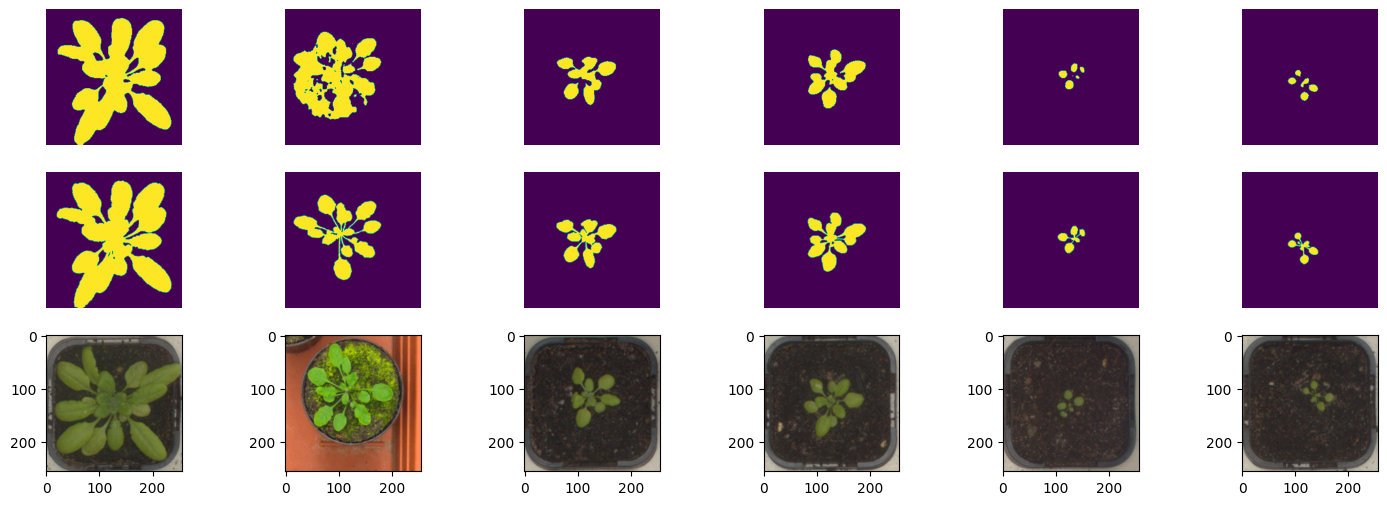

In [33]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(Y_hat[i][0])

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(Y_val[i][0])
    plt.axis("off")
    plt.subplot(3, 6, i+13)
    plt.imshow(X_val[i].T)
plt.show();

In [34]:
torch.save(model, 'model.pth')